In [1]:
import torch
from gensim.models import Word2Vec
import torch.nn as nn
import cv2
from matplotlib.pyplot import imshow
import numpy as np

In [2]:
w2v = Word2Vec.load("bare_minimum")
w2v.wv["bear"].shape

(16,)

In [3]:
w2v.wv.__len__()

10

In [4]:
bear = cv2.imread("bear.jpg")
bear = cv2.resize(bear,(128,128))
hospital = cv2.imread("hos.png")
hospital = cv2.resize(hospital,(128,128))
strike = cv2.imread("strike.jpg")
strike = cv2.resize(strike,(128,128))
imgs = np.array([(i.reshape(1,3,128,128) / 256).astype(np.float32) for i in [bear, hospital, strike]])

In [ ]:
# MAKE SURE YOU ADD ANY LAYERS TO THE FORWARD FUNCTION
# THE GOAL IS COLOR
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(16, 256, bias=False)
        # Try upscaling more linearly, but make sure it is a square number that can be upscaled by 2 to 128
        
        self.upsample1 = nn.ConvTranspose2d(1, 1, 3, 2, 1, 1, bias=False)
        self.upsample2 = nn.ConvTranspose2d(1, 1, 3, 2, 1, 1, bias=False)
        self.upsample3 = nn.ConvTranspose2d(1, 1, 3, 2, 1, 1, bias=False)
        # Try modifying the in/out channels and kernel sizes here. 
        # Can also add normal Conv layers between these, just make sure padding = kernel_size // 2
        
        self.mesh = nn.Conv2d(4, 3, 3, padding=1, bias=False)
        # Try adding additional layers here, since this is the place where
        # the current sentence image is merged with the word
        
    def forward(self, word_vec, simage):
        
        x = self.dense1(word_vec)
        x = nn.functional.relu(x)
        
        x = x.reshape((-1,1,16,16))
        
        x = self.upsample1(x)
        x = nn.functional.relu(x)
        x = self.upsample2(x)
        x = nn.functional.relu(x)
        x = self.upsample3(x)
        x = nn.functional.relu(x) # <- This activation function should result in something image-like, relu isn't great
        
        # Make modifications here too
        
        x = torch.concat((simage, x), dim=1)
        return self.mesh(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.conv3 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        
        self.pool1 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.pool2 = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(3,6,3,padding=1, bias=False)
        self.pool3 = nn.MaxPool2d(2)
        self.conv6 = nn.Conv2d(6,1,3,padding=1, bias=False)
        
        self.flatten = nn.Flatten()
        self.classify1 = nn.Linear(266,128, bias=False)
        self.classify2 = nn.Linear(128,64, bias=False)
        self.classify3 = nn.Linear(64, 10, bias=False)
        
        self.next1 = nn.Conv2d(3,16,3,padding=1, bias=False)
        self.next2 = nn.Conv2d(16,16,3,padding=1, bias=False)
        self.next3 = nn.Conv2d(16, 3, 1, bias=False)
        
        
    def forward(self, input, context):
        
        x = self.conv1(input)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        
        c = self.pool1(x)
        c = self.conv4(c)
        c = nn.functional.relu(c)
        c = self.pool2(c)
        c = self.conv5(c)
        c = nn.functional.relu(c)
        c = self.pool3(c)
        c = self.conv6(c)
        c = nn.functional.relu(c)

        c = self.flatten(c)
        c = torch.concat((c, context), dim=1)
        c = self.classify1(c)
        c = nn.functional.relu(c)
        c = self.classify2(c)
        c = nn.functional.relu(c)
        c = self.classify3(c)
        
        n = self.next1(x)
        n = nn.functional.relu(n)
        n = self.next2(n)
        n = nn.functional.relu(n)
        n = self.next3(n)
        n = nn.functional.sigmoid(n)
        
        return c, n

In [6]:
torch.manual_seed(42)
enc = Encoder()
dec = Decoder()

In [7]:
a = enc(torch.from_numpy(w2v.wv['bear']), torch.zeros(1,3,128,128))
dec(a, torch.zeros(1,10))

C:\Users\Alexander\AppData\Local\Temp\ipykernel_20216\1061091042.py:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  a = enc(torch.from_numpy(w2v.wv['bear']), torch.zeros(1,3,128,128))


(tensor([[-2.0736e-09, -2.4735e-09,  2.4544e-10, -1.2509e-09,  1.6326e-09,
           1.8307e-09, -7.8641e-10, -9.3662e-10,  6.8639e-10, -1.0873e-09]],
        grad_fn=<MmBackward0>),
 tensor([[[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           ...,
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
 
          [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           ...,
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
           [0.5000, 0.5000, 0.5000,  ..., 0.

In [8]:
sentences = [["the", "bear", "is", "eating", "honey"],
             ["where", "is", "the", "hospital"],
             ["students", "are", "striking"]]
images = torch.tensor(imgs)

In [9]:
# define optim
crit_words = nn.CrossEntropyLoss()
crit_image = nn.MSELoss()

s = nn.ModuleList([enc,dec])

optim = torch.optim.Adam(s.parameters())

In [ ]:
## Training loop
epochs = 500
for epoch in range(epochs):
    sents = []
    for img,sent in zip(images,sentences):
        optim.zero_grad()
        canvas = torch.zeros(1,3,128,128)
        for w in sent:
            canvas = enc(torch.from_numpy(w2v.wv[w]).float(), canvas)
        # Try modifying weights or training scheme
        loss = crit_image(img, canvas)
        pic = canvas.clone()
        context = torch.zeros(1,10)
        outs = []
        for w in sent:
            word, canvas = dec(canvas, context)
            context = word
            loss = loss + crit_words(word, torch.tensor([w2v.wv.key_to_index[w]]))
            outs.append(word)
        loss.backward()
        optim.step()
        sents.append(outs)

In [11]:
[[w2v.wv.index_to_key[w.argmax()] for w in sen] for sen in sents]

[['the', 'bear', 'is', 'eating', 'honey'],
 ['where', 'is', 'the', 'hospital'],
 ['is', 'are', 'striking']]

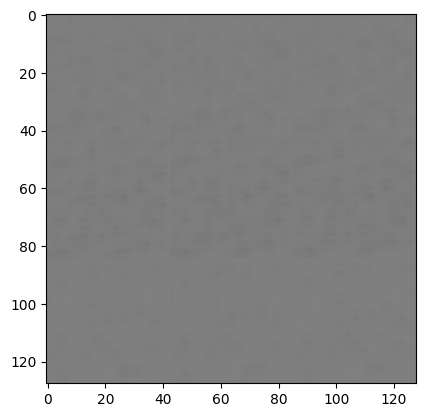

In [12]:
imshow(nn.functional.sigmoid(pic).detach().numpy().reshape(128,128,3))

In [16]:
pic[:,:,0] - pic[:,:,2]

tensor([[[ 1.1581e-02,  1.3579e-02,  1.1514e-02,  9.3587e-03,  1.1115e-02,
           1.3435e-02,  1.3103e-02,  1.0544e-02,  7.5137e-03,  4.8343e-03,
           2.1299e-03,  1.5238e-03,  1.8880e-03,  4.9103e-04, -7.4764e-04,
          -1.1040e-03, -1.3729e-03, -3.4934e-03, -4.2591e-03, -1.6432e-03,
           3.1957e-03,  5.7850e-03,  7.0682e-03,  8.4576e-03,  1.0461e-02,
           1.1829e-02,  1.1944e-02,  9.8908e-03,  6.9048e-03,  4.2714e-03,
           4.3449e-03,  7.9571e-03,  1.3619e-02,  1.5930e-02,  1.3946e-02,
           1.0884e-02,  1.1348e-02,  1.3519e-02,  1.4078e-02,  1.2708e-02,
           1.1294e-02,  9.2760e-03,  6.8279e-03,  5.9191e-03,  7.5772e-03,
           8.6469e-03,  9.1427e-03,  8.3020e-03,  7.3595e-03,  7.1777e-03,
           6.8982e-03,  5.8082e-03,  4.0946e-03,  2.4017e-03,  1.9825e-03,
           4.0141e-03,  7.1300e-03,  8.4184e-03,  6.9878e-03,  5.0013e-03,
           4.1691e-03,  4.2606e-03,  6.6188e-03,  1.2017e-02,  2.0280e-02,
           2.3321e-02,  2